# AGU 2021 - Predictive Models of Ionospheric Convection Patterns During Substorms Related to STEVE

First Author: Willem Mirkovich, Ann and H.J. Smead Aerospace Engineering Sciences University of Colorado Boulder

Authors: 
- Tomoko Matsuo, Ann and H.J. Smead Aerospace Engineering Sciences University of Colorado Boulder
- Valerie Svaldi, Colorado School of Mines

## Introduction

Welcome to my Jupyter Notebook going over my work for AGU 2021. 

My AGU 2021 Session: https://agu.confex.com/agu/fm21/meetingapp.cgi/Paper/955609

Full Repository for AGU 2021: https://github.com/willemmirkovich/AGU-2021

This notebook will cover my work using a genetic algorithm to create a prediction model for Principal Component 3 coefficient for 32 STEVE events. 

<mark>NOTE:</mark> This notebook will focus on the implementation of the genetic algorithm and explanation of how it is used. For more information regarding STEVE, please refer to my colleague Valerie Svaldi's work [here](https://agu.confex.com/agu/fm21/meetingapp.cgi/Paper/900392), or watch my video [here](TODO: needed) that gives a bit more of an overview. #### TODO: need to get link for video

## Goal

The overall goal of this project is to create a predictive model predicting Principal Component 3 (PC3) coefficients. 

$$ \text{PC3}: y $$

To predict this value, we will be using a subset of the features available from 32 STEVE events. We will have $M$ defined as all subsets of the possible features, which include AL index, By, Bz, and hour. 

A specific set of features we will use to predict PC3 will be defined as $\mu$

$$ \mu \in {M} $$

Some examples of $\mu$ would be: [AL index, By], [By, Bz], ...

To see what these features are, please look at the bottom of this notebook for definitions.

Therefore, we can create input data for this model by using $x^\mu$, which will be input data using $\mu$ features.

We can also look back $t$ time steps back to predict a value of PC3 at time a given time. We can define $x^\mu_-t$ as input data that is $t$ time steps back from the current target time.

With these definitions, we can state our goal as 

$$f(x^\mu_0, x^\mu_{-1}, ... x^\mu_{t}) = \hat{y}$$

Where $f$ is a model that will produce an estimated value for $y$ given input data from $t$ time steps

## Automated selection of hyperparameters/features

To create this model, an automated approach will be used to build this model.  

Our goal is to develop this model based on the following problem: minimizing the loss of a model given a set of features and hyperparameters to choose from.

We will define all of the valid sets of hyperparameters to choose from as $\Lambda$ and $\lambda$ as one of those sets.

$$\lambda \in \Lambda$$

We can do this by creating a model with some subset of features $\mu$ and some subset of hyperparameters $\lambda$, training this model, and evaluating its loss on our validation data set. 

Training data: $S_t$

Model trained on $S_t$ and using hyperparameters $\lambda$: $f^\lambda_{S_t}$

Loss of a estimated value compared to its actual value: $l(\hat{y}, y)$

We can compare this loss to other models with different subsets of features and hyperparameters, and eventually find a model that minimizes our loss the validation data. 

Validation Data: $S_v$

We will define this as the **Learning Algorihtm**: $$\displaystyle\min_{\lambda \in \Lambda, \mu \in M} \displaystyle\sum_{(x^{\mu},y) \in S_v} l(f^{\lambda}_{S_t}(x^{\mu}), y)$$

By optimizing this problem, we can find the hyperparameters/features we will use for this model.

## Data Prep

Now that we have our definitions out of the way, we can start by getting our data from 32 STEVE events

In [1]:
# get a pandas dataframe of our 32 steve events
import pandas as pd
df = pd.read_csv('./32_STEVE_EVENTS_Labeled_df.csv')
df.head(10)

,Unnamed: 0,By,Bz,PC1,PC2,PC3,PC4,SML,cpcp,hour,time,hourbin,event
0,0,-1.67,3.42,64653.004077,-160358.825318,-47353.417436,39646.871925,-116.0,32.291413,-1.200000,2008-02-11 08:00:00,-1.25,1
1,1,-3.18,2.92,102649.640291,-185430.396101,-45396.211333,3023.915222,-125.0,29.960107,-1.116667,2008-02-11 08:05:00,-1.00,1
2,2,-3.41,2.75,161835.469554,-166707.536381,-19485.696443,-6327.593162,-94.0,26.918939,-1.033333,2008-02-11 08:10:00,-1.00,1
3,3,-2.03,2.74,199768.528492,-179418.730394,-10756.192864,-31623.419630,-125.0,23.472209,-0.950000,2008-02-11 08:15:00,-1.00,1
4,4,-0.98,3.60,205430.249457,-153430.863222,837.938185,-5341.239062,-60.0,16.059939,-0.866667,2008-02-11 08:20:00,-0.75,1
5,5,-1.97,2.79,164000.429474,-168152.728636,-3507.392011,-1415.432512,-60.0,17.826138,-0.783333,2008-02-11 08:25:00,-0.75,1
6,6,-1.04,1.72,199026.704485,-149993.688634,-5979.775528,-4165.377081,-53.0,16.332872,-0.700000,2008-02-11 08:30:00,-0.75,1
7,7,-0.36,0.91,217921.261187,-153637.970165,8227.489723,-10762.291475,-208.0,14.661210,-0.616667,2008-02-11 08:35:00,-0.50,1
8,8,0.17,-0.48,198457.200588,-162027.568209,23929.696916,-27709.399973,-210.0,14.249256,-0.533333,2008-02-11 08:40:00,-0.50,1
9,9,-0.55,-3.35,197921.049353,-151450.095445,29808.295028,-27652.938049,-217.0,15.308488,-0.450000,2008-02-11 08:45:00,-0.50,1


Before diving further, need trim this data to remove NA values on By/Bz, which there exists only a couple events where this is the case. These NA values also exist on the front/end of the events in question, and will not impact the time series component. 

Number of observations: 1637
Number of observations with non NA values: 1574


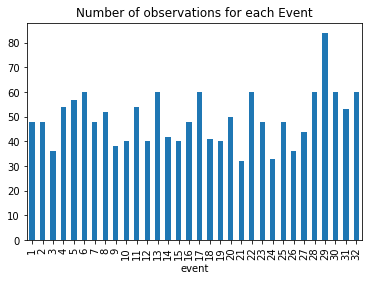

In [2]:
df_test = df[df['By'].notna()]
df_test = df_test[df_test['Bz'].notna()]
print('Number of observations: %s' % len(df))
print('Number of observations with non NA values: %s' % len(df_test))
ax = df_test.groupby('event').size().plot.bar(y='event')
ax.set_title('Number of observations for each Event')
df = df_test

## Packaging the Data

Now that we have our data, we can package it to be more friendly with Tensorflow and various plotting. This will be accomplished using Xarray

In [3]:
from datetime import datetime

def to_datetime(s):
    """
    Transforms a 'time' string from our data to a datetime object
    """
    year = int(s[0:4])
    month = int(s[5:7])
    day = int(s[8:10])
    hour = int(s[11:13])
    minute = int(s[14:16])
    second = int(s[17:19]) 
    return datetime(year, month, day, hour, minute, second)
df_times = [to_datetime(el) for el in df['time']]

In [4]:
import xarray as xa
ds = xa.Dataset(data_vars={
    "al": xa.DataArray(
       data=df['SML'],
       dims='time',
       coords={
            'time': df_times,
        }
    
    ),
    "pc1": xa.DataArray(
        data=df['PC1'],
        dims='time',
        coords={
            'time': df_times,
        }
    ),
    "pc2": xa.DataArray(
        data=df['PC2'],
        dims='time',
        coords={
            'time': df_times,
        }
    ),
    "pc3": xa.DataArray(
        data=df['PC3'],
        dims='time',
        coords={
            'time': df_times,
        }
    ),
    "pc4": xa.DataArray(
        data=df['PC4'],
        dims='time',
        coords={
            'time': df_times,
        }
    ),
    "event": xa.DataArray(
        data=df['event'],
        dims='time',
        coords={
            'time': df_times,
        }
    ),
    "cpcp": xa.DataArray(
        data=df['cpcp'],
        dims='time',
        coords={
            'time': df_times,
        }
    ),
    "by": xa.DataArray(
        data=df['By'],
        dims='time',
        coords={
            'time': df_times,
        }
    ),
    "bz": xa.DataArray(
        data=df['Bz'],
        dims='time',
        coords={
            'time': df_times,
        }
    ),
    "hour": xa.DataArray(
        data=df['hour'],
        dims='time',
        coords={
            'time': df_times,
        }
    )
})
print('Our STEVE Events DataSet')
ds

Our STEVE Events DataSet


<xarray.Dataset>
Dimensions:  (time: 1574)
Coordinates:
  * time     (time) datetime64[ns] 2008-02-11T08:00:00 ... 2018-07-17T09:25:00
Data variables:
    al       (time) float64 -116.0 -125.0 -94.0 -125.0 ... -94.0 -78.0 -88.0
    pc1      (time) float64 6.465e+04 1.026e+05 1.618e+05 ... 2.053e+05 2.22e+05
    pc2      (time) float64 -1.604e+05 -1.854e+05 ... -1.169e+05 -1.586e+05
    pc3      (time) float64 -4.735e+04 -4.54e+04 ... 4.915e+04 4.289e+04
    pc4      (time) float64 3.965e+04 3.024e+03 ... 3.058e+04 1.005e+04
    event    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 32 32 32 32 32 32 32 32 32 32
    cpcp     (time) float64 32.29 29.96 26.92 23.47 ... 21.58 20.86 24.85 20.44
    by       (time) float64 -1.67 -3.18 -3.41 -2.03 ... 0.43 0.71 0.26 0.43
    bz       (time) float64 3.42 2.92 2.75 2.74 3.6 ... 2.53 4.59 4.74 4.2 4.2
    hour     (time) float64 -1.2 -1.117 -1.033 -0.95 ... 3.8 3.883 3.967 4.05

## Splitting the data

Now that we have our data in an easy to manage DataSet, we can split it into the train/valid/test divisions we need

The split will be as follows:

- 22 Train Events (~70%)
- 7 Valid Events (~20%)
- 3 Test Events (~10%)

In [5]:
import numpy as np
events = np.array([i for i in range(1, 33)])
events

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

We can choose these events randomly, or by preselection. For this notebook, either can be chosen but the preselected events will be the default

In [6]:
# Random
shuffled_events = np.random.permutation(events)
train = shuffled_events[:22]
valid = shuffled_events[22:29]
test = shuffled_events[29:]

In [7]:
# preselected
valid = np.array([8, 21, 29, 6, 27, 1, 23])
test = np.array([9, 30, 14])
train = np.array(np.setdiff1d(events, np.concatenate((valid, test))))

In [8]:
print('Train Events: %s' % train)
print('Valid Events: %s' % valid)
print('Test Events: %s' % test)

Train Events: [ 2  3  4  5  7 10 11 12 13 15 16 17 18 19 20 22 24 25 26 28 31 32]
Valid Events: [ 8 21 29  6 27  1 23]
Test Events: [ 9 30 14]


## Interacting with the Data

Now that we have our splits, we can package our data given a set of features using the following functions. For this, using a DataArray will be easier to do this

In [9]:
# transform our Dataset into a DataArray
da = ds.to_array().T
# add coordinate event to each element in the DataArray
event = ds['event']
da = da.assign_coords(event=('time', event))
da

<xarray.DataArray (time: 1574, variable: 10)>
array([[-1.16000000e+02,  6.46530041e+04, -1.60358825e+05, ...,
        -1.66999996e+00,  3.42000008e+00, -1.20000000e+00],
       [-1.25000000e+02,  1.02649640e+05, -1.85430396e+05, ...,
        -3.18000007e+00,  2.92000008e+00, -1.11666667e+00],
       [-9.40000000e+01,  1.61835470e+05, -1.66707536e+05, ...,
        -3.41000009e+00,  2.75000000e+00, -1.03333333e+00],
       ...,
       [-9.40000000e+01,  2.25964111e+05, -1.51069214e+05, ...,
         7.09999979e-01,  4.73999977e+00,  3.88333333e+00],
       [-7.80000000e+01,  2.05279772e+05, -1.16872714e+05, ...,
         2.59999990e-01,  4.19999981e+00,  3.96666667e+00],
       [-8.80000000e+01,  2.22009057e+05, -1.58579067e+05, ...,
         4.30000007e-01,  4.19999981e+00,  4.05000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2008-02-11T08:00:00 ... 2018-07-17T09:25:00
  * variable  (variable) <U5 'al' 'pc1' 'pc2' 'pc3' ... 'cpcp' 'by' 'bz' 'hour'
    event     (time) int64 1 1 1 1 1 1 1 1 1 1 ... 32 32 32 32 32 32 32 32 32 32

In [10]:
def get_variable_indices(variables):
    """
    Returns indices of the features in our newly formed DataArray
    """
    t = {
        'al': 0,
        'pc1': 1,
        'pc2': 2,
        'pc3': 3, 
        'pc4': 4,
        'event': 5,
        'cpcp': 6,
        'by': 7,
        'bz': 8,
        'hour': 9
    }
    return [(key in variables) for key in t]

def get_indices(event_type):
    return ds['event'].isin(event_type).values.flatten()

def get_data(data_vars, event_type):
    return da.loc[get_indices(event_type)][:, get_variable_indices(data_vars)]

In [11]:
def split(features, pred):
    """
    Will return X, Y based on features provided
    """
    X_train, X_valid, X_test = get_data(features, train), get_data(features, valid), get_data(features, test)
    Y_train, Y_valid, Y_test = get_data(pred, train), get_data(pred, valid), get_data(pred, test)
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test 

X_train, _, X_valid, _, X_test, _ = split(['al', 'by'], 'pc3')
len(X_train), len(X_valid), len(X_test)

(1066, 368, 140)

To scale our data for our model, RobustScaler will be used due to the amount of outliers that exist in our data from the 32 STEVE events

In [12]:
from sklearn.preprocessing import RobustScaler

def create_scaler(d):
    """
    Will create a scaler function using Skl
    
    How to use: 
        scaler.transform(d) => scale
        scaler.inverse_transform(d) => unscale
    """
    scaler = RobustScaler()
    scaler.fit(d)
    return scaler

In [13]:
def scale(d, scaler):
    """
    Will scale a DataArray using scaler
    """
    scaled = scaler.transform(d)
    new_d = xa.DataArray(
        data=scaled,
        dims=['time', 'feature'],
        coords={
            'time': d.time
        }
    )
    new_d = new_d.assign_coords(event=('time', d.event))
    return new_d
    
def unscale(d, scaler):
    """
    Will unscale a DataArray using scaler
    """
    unscaled = scaler.inverse_transform(d)
    new_d = xa.DataArray(
        data=unscaled,
        dims=['time', 'feature'],
        coords={
            'time': d.time
        }
    )
    new_d = new_d.assign_coords(event=('time', d.event))
    return new_d

Now that scaling is over and done with, windowing will be used to create input data that utilizes multiple time steps for input into our model.

In [14]:
def window_Y(data, time_steps=0):
    """
    Windows Y data, returns a DataArray
    """
    spec_events = np.unique(data.event)
    
    new, times, events = [], [], []
    
    for e in spec_events:
        temp = data.loc[data.event ==  e]
        for i in range(time_steps, len(temp)):
            new.append(temp[i])
            times.append(temp[i].time.values)
            events.append(temp[i].event.values)
    new_da = xa.DataArray(
        data=new,
        dims=['time', 'features'],
        coords={
            'time': times 
        }
    )
    new_da = new_da.assign_coords(event=('time', events))
    return new_da
    
def window_X(data, time_steps=0):
    """
    Windows X data, returns a DataArray
    """
    # dim1 = batch
    # dim2 = time
    # dim3 = feature
    spec_events = np.unique(data.event)
    
    new = []
    times = []
    events = []
    
    batch_events = []
    
    for e in spec_events:
        temp = data.loc[data.event == e]
        for i in range(time_steps, len(temp)):
            new.append([el for el in temp[i-time_steps:i+1].values])
            times.append([el for el in temp.time[i-time_steps:i+1].values])
            events.append([el for el in temp.event[i-time_steps:i+1].values])
            # special case for multiple time steps back, time not as important
            batch_events.append(e)
    new = np.array(new)
    times = np.array(times)
    events = np.array(events)
    batch_events = np.array(batch_events)
    if (time_steps == 0):
        new = new[:, 0, :]
        times = times[:, 0]
        events = events[:, 0]
        new_da = xa.DataArray(
            data=new,
            dims=['time', 'features'],
            coords={
                'time': times
            }
        )
        new_da = new_da.assign_coords(event=('time', events))
        return new_da
    else:  
        new_da = xa.DataArray(
            data=new,
            dims=['batch', 'time', 'features']
        )
        new_da = new_da.assign_coords(event=('batch', batch_events))
        return new_da
    
# number of time steps to look back
t = 4
d = window_X(X_train, t)
# batch, time, features
d.shape

(978, 5, 2)

One final helper function will be to predict and package the output from that precition into a DataArray for plotting/analysis

In [15]:
def predict(model, x, times, events):
    try:
        y = model.predict(x.values)
    except:
        y = model.predict(x)
    new_d = xa.DataArray(
        data=y,
        # NOTE: feature is not used here, but needed for [time, 1] shape
        dims=['time', 'feature'],
        coords={
            'time': times
        }
    )
    new_d = new_d.assign_coords(event=('time', events))
    return new_d

With the above functions, it should be fairly easy to create a model and its correct inputs/outputs

## Genetic Algorithm

Now that we have a way to generate data for a model using some set of features, we can get into using a Genetic Algorithm to build our model in an automated fashion. 

Since it has been used in other machine learning applications for selecting hyperparameters (see [here](https://arxiv.org/abs/2006.12703) for one example), the genetic algorithm has been chosen to automate our generation of a model.

A genetic algorithm works be creating a random initial population of candidates, which for this problem will be models with specific hyperparameters that use some subset of features, and then creating new generations of populations with the best traits from previous generations. 

![genetic algorithm](./static/AGU-Genetic.png)

This is done by evaluating individual members in a population by a fitness function, and then selecting by weighted probability the best members from a generation to create new members for the next generation. I am using a rank based fitness evaluation for members

$$\text{Fitness function for member } i = g_i $$

$$ g_i = \frac{n + 1 - r_i}{\sum_{j \in P}(n + 1 - r_j)}$$

and using a binary cross over approach to generate new member from 2 selected members

![crossover function](./static/AGU-Binary.png)

After X many generations, we hope to find a member that has collected the best features and hyperparameters to use for our predictive model.

<mark>NOTE:</mark>The rank based fitness function was found in this paper using a gentic algorithm to optimize CNN hyperparameters: https://ieeexplore.ieee.org/abstract/document/9177040/citations#citations

To see the source for the genetic algorithm, look at ```genetic_algorithm.py``` in this directory

In [16]:
from tensorflow.keras.losses import MeanSquaredError
"""
The loss function being used: Mean Squared Error
"""
loss_fn = MeanSquaredError() # NOTE: this is the best one!

Below is the feature/hyperparameter pool that will be used for this model

In [17]:
pool = {
    'al': [0, 1], 
    'by': [0, 1], 
    'bz': [0, 1], 
    'hour': [0, 1],
    'time_lag': [0, 1, 2, 3, 4, 5, 6, 7],
    'layer_1_units': [4, 8, 12, 16, 32, 48, 64], # NOTE: layer 1 cannot be 0
    'layer_2_units': [0, 4, 8, 12, 16, 32, 48, 64],
    'layer_3_units': [0, 4, 8, 12, 16, 32, 48, 64],
    'layer_4_units': [0, 4, 8, 12, 16, 32, 48, 64]
}

Here are the helper function that will be used by the genetic algorithm for this specific problem

In [18]:
def generate_model(genes):
    """
    Generates a random model from a gene pool
    """
    model = Sequential()
    if (genes['time_lag'] != 0):
        model.add(LSTM(units=genes['layer_1_units']))
    else:
        model.add(Dense(units=genes['layer_1_units'], activation='relu'))
    if (genes['layer_2_units'] != 0):
        model.add(Dense(units=genes['layer_2_units'], activation='relu'))
    if (genes['layer_3_units'] != 0):
        model.add(Dense(units=genes['layer_3_units'], activation='relu'))
    if (genes['layer_4_units'] != 0):
        model.add(Dense(units=genes['layer_4_units'], activation='relu'))
    model.add(Dense(units=1))
    return model

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
    
def compile_and_fit(model, X_train, Y_train, epochs=20):
    """
    Compiles a model, and trains using X_train and Y_train
    """
    model.compile(loss=loss_fn,
                optimizer=Adam())

    history = model.fit(X_train, Y_train, epochs=epochs, verbose=0)
    return history

def fill_member(member, epochs): 
    """
    Given a population member, will generate X, Y based on time steps being used and features
    
    Will train the model the generated X, Y
    """
    lags = member['genes']['time_lag']
    
    pred = 'pc3'
    
    features = []
    (features.append('al') if member['genes']['al'] == 1 else None)
    (features.append('by') if member['genes']['by'] == 1 else None)
    (features.append('bz') if member['genes']['bz'] == 1 else None)
    (features.append('hour') if member['genes']['hour'] == 1 else None)
    
    # NOTE: if no features included in genes, force a mutation and include one feature
    if len(features) == 0:
        c = np.random.choice(['al', 'by', 'bz', 'hour'])
        member['genes'][c] = 1
        features.append(c)
   
    X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split(features, pred)
    
    member['X_scaler'] = create_scaler(X_train) 
    member['Y_scaler'] = create_scaler(Y_train)
    
    member['train'] = {}
    member['train']['X'] = scale(X_train, member['X_scaler'])
    member['train']['Y'] = scale(Y_train, member['Y_scaler'])
    member['valid'] = {}
    member['valid']['X'] = scale(X_valid, member['X_scaler'])
    member['valid']['Y'] = scale(Y_valid, member['Y_scaler'])
    member['test'] = {}
    member['test']['X'] = scale(X_test, member['X_scaler'])
    member['test']['Y'] = scale(Y_test, member['Y_scaler'])
    
    member['train']['X'] = window_X(member['train']['X'], lags) 
    member['train']['Y'] = window_Y(member['train']['Y'], lags) 
    member['valid']['X'] = window_X(member['valid']['X'], lags) 
    member['valid']['Y'] = window_Y(member['valid']['Y'], lags) 
    member['test']['X'] = window_X(member['test']['X'], lags) 
    member['test']['Y'] = window_Y(member['test']['Y'], lags) 
    
    member['model'] = generate_model(member['genes'])
    hist = compile_and_fit(member['model'], member['train']['X'].values, member['train']['Y'].values, epochs=epochs)
    member['val_loss'] = member['model'].evaluate(member['valid']['X'].values, member['valid']['Y'].values, verbose=0)

And finally, we can put it into action.

<mark>NOTE:</mark> for the purposes of showing quick results, I have modified these values from their original to get quick plots and model results, but feel free to modify these values as you see fit.

In [19]:
# my implementation of the genetic algorithm
from genetic_algorithm import genetic_algorithm

# NOTE: for the results presented at AGU 2021, size=30 and generatations=4
hist, best_member = genetic_algorithm(pool, size=5, generations=2, fill_member=fill_member)

Generating Initial Population



Initial Population Generated
Generating Population 1



Generation 1 complete
Generating Population 2



Generation 2 complete


We can see what the tensorflow model returned by the genetic algorithm looks like

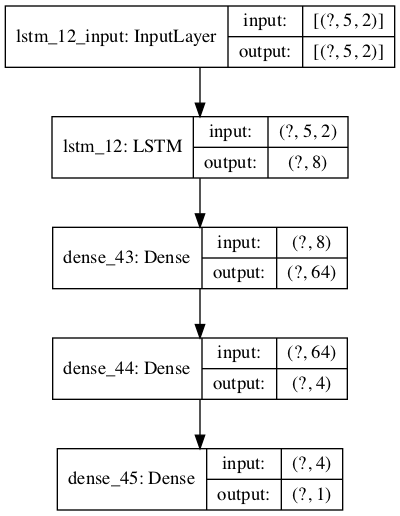

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(best_member['model'], show_shapes=True, to_file="model.png")

In [21]:
# remove file from dir
from os import remove
remove('model.png')

And what features/hyperparameters were selected

In [22]:
best_member['genes']

{'al': 1,
 'by': 0,
 'bz': 1,
 'hour': 0,
 'time_lag': 4,
 'layer_1_units': 8,
 'layer_2_units': 64,
 'layer_3_units': 0,
 'layer_4_units': 4}

In [23]:
print('Test Loss: %s (Mean Squared Error)' % best_member['model'].evaluate(best_member['test']['X'].values, best_member['test']['Y'].values, verbose=0))
print('Validation Loss: %s (Mean Squared Error)' % best_member['model'].evaluate(best_member['valid']['X'].values, best_member['valid']['Y'].values, verbose=0))

Test Loss: 0.26860588788986206 (Mean Squared Error)
Validation Loss: 0.5499116778373718 (Mean Squared Error)


## Results

Now that we have our model from the automated generation approach, we can plot some interesting results

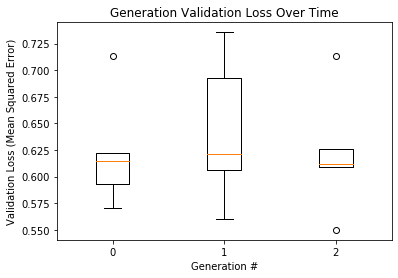

In [24]:
import matplotlib.pyplot as plt

def plot_generation_fitness(ax, history):
    d = []
    gens = []
    for g in range(len(history)):
        gens.append(g)
        d.append(history[g]['fitness'])
    ax.boxplot(d, positions=gens)
    ax.set_ylabel('fitness')
    ax.set_xlabel('generation')
    ax.set_title('Generation fitness over time')
    
def plot_generation_val_loss(ax, history):
    """
    Plots Validation loss over generations from the genetic algorithm
    """
    d = []
    gens = []
    for g in range(len(history)):
        gens.append(g)
        d.append(history[g]['val_loss'])
    ax.boxplot(d, positions=gens)
    ax.set_ylabel('Validation Loss (Mean Squared Error)')
    ax.set_xlabel('Generation #')
    ax.set_title('Generation Validation Loss Over Time')
    
fig, ax = plt.subplots()
plot_generation_val_loss(ax, hist)

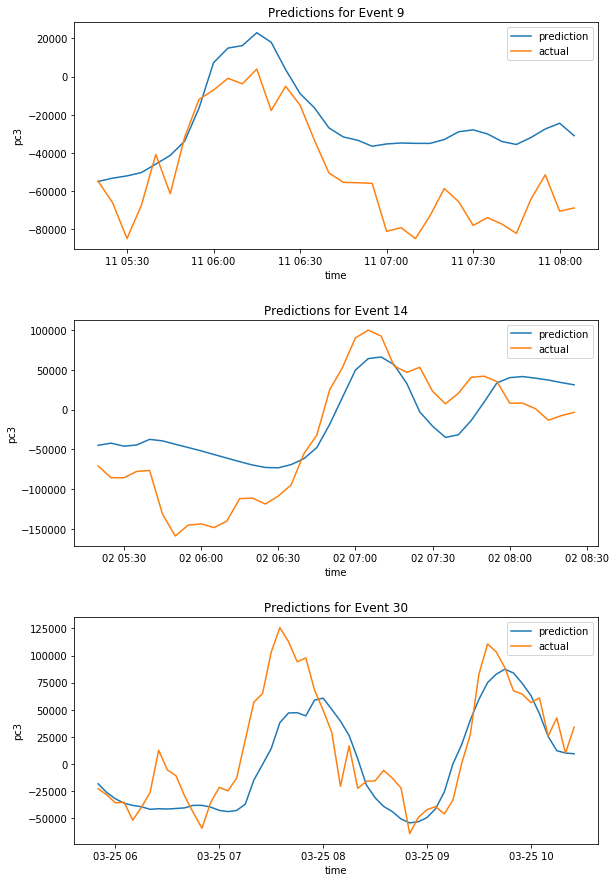

In [25]:
def plot_event_pred(ax, p, y, event_num):
    ax.plot(y.time, p, label='prediction')
    ax.plot(y.time, y, label='actual')
    ax.set_xlabel('time')
    ax.set_ylabel('pc3') # TODO: get units here
    ax.set_title('Predictions for Event %s' % event_num)
    ax.legend()

def plot_test_events(member):
    """
    Plots the prediction results for a member for its 3 test events
    """
    
    # get each test event
    events = np.unique(member['test']['Y'].event)
    
    # plot
    fig, axs = plt.subplots(len(events), figsize=(8, (4 * len(events))))
    fig.tight_layout(h_pad=5)
    for i in range(0, len(events)):
        ax = axs[i]
        event_num = events[i]
        X_test = member['test']['X'].loc[member['test']['X'].event == event_num]
        Y_test = member['test']['Y'].loc[member['test']['Y'].event == event_num]
        pred = predict(member['model'], X_test, Y_test.time, Y_test.event)
        pred = unscale(pred, member['Y_scaler'])
        y = unscale(Y_test, member['Y_scaler'])
        plot_event_pred(ax, pred, y, event_num)
    return fig
    
fig = plot_test_events(best_member)

## References

Valerie Svaldi's work inspired and generated data for this project: https://agu.confex.com/agu/fm21/meetingapp.cgi/Paper/900392 

The assimilative mapping analysis (which was used to create the data) is produced with the use of the AMGeO open source software (doi:10.5281/zenodo.3564915) available upon registration at https://amgeo.colorado.edu/

The fitness function used and inspiration for equations defining the problem were collected from:

    F. Johnson, A. Valderrama, C. Valle, B. Crawford, R. Soto and R. Ñanculef, "Automating Configuration of Convolutional Neural Network Hyperparameters Using Genetic Algorithm," in IEEE Access, vol. 8, pp. 156139-156152, 2020, doi: 10.1109/ACCESS.2020.3019245.

## Defintions

**STEVE**

The name “STEVE” stands for “Strong Thermal Emission Velocity Enhancement”. These events are categorized by a purplish arc with a green “picket fence” feature that runs east to west and appears closer to the equator than regular aurora. Recently discovered” by citizen observers in 2016,  we know that the emission is different from traditional auroras, yet the physical mechanism driving these events isn’t completely understood.

**AL/ SML**

The Auroral Electrojet Index, AE, is designed to provide a global, quantitative measure of     auroral zone magnetic activity produced by enhanced ionospheric currents flowing below and within the auroral oval. 
Ideally, It is the total range of deviation at an instant of time from quiet day values of the horizontal magnetic field (h) around the auroral oval.

AL- lower envelope of the Northern Hemisphere, shows electrojet strength increases in the westward direction 
SML-SuperMAG version of AL index 

There is a total of 12 ground based magnetometer stations that are used for the official auroral electrojet indices (AE = AU -AL), whereas over 100 magnetometer stations in collaboration with SuperMAG are used to derive the SuperMAG auroral electrojet indies (SME = SMU - SML)

**By/Bz**

Magnetic fields, denoted by B, are carried through the heliosphere by the solar wind and are constantly changing in direction and strength
The interplanetary magnetic field is a vector quantity with a three axis component, two of which (Bx and By) are orientated parallel to the ecliptic. 

Bz north is in the tangent direction as the Earth’s magnetic field 

Bz south is the opposite direction Earth's magnetic field

Southward Bz's often relate to widespread auroras, triggered by solar wind gusts or coronal mass ejections that are able to inject energy into our planet's magnetosphere.